In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
!pip install missingno
import missingno as msno

In [3]:
titanic = sns.load_dataset("titanic")
df = titanic.copy()
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


In [4]:
def missing_value_table(dataframe, na_names=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

  if na_names:
    print(25*"#", "NA Columns", 25*"#")
    return na_columns

In [5]:
missing_value_table(df, na_names=True)

             n_miss  ratio
deck            688 77.220
age             177 19.870
embarked          2  0.220
embark_town       2  0.220
######################### NA Columns #########################


['age', 'embarked', 'deck', 'embark_town']

In [6]:
df.dropna().head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True


In [7]:
def fill_na_with_mean(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.mean()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [8]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [9]:
def fill_na_with_mode(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [10]:
def fill_na_with_mode(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype != 'O' and len(x.unique()) <= 10) else x, axis=0)
  return dataframe

In [11]:
def fill_na_with_cat(dataframe, col_name, cat_col):
  dataframe[col_name] = dataframe[col_name].fillna(df.groupby(cat_col)[col_name].transform("mean"))
  return dataframe[col_name]

In [12]:
df.loc[(df["age"].isnull()) & (df["sex"] == "female"), "age"] = df.groupby("sex")["age"].mean()["female"]
df.loc[(df["age"].isnull()) & (df["sex"] == "male"), "age"] = df.groupby("sex")["age"].mean()["male"]

In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    return cat_cols, num_cols, cat_but_car, num_but_cat

In [14]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
print(f"observations: {df.shape[0]}")
print(f"variables: {df.shape[1]}")
print(f"cat_cols: {len(cat_cols)}")
print(f"num_cols: {len(num_cols)}")
print(f"cat_but_car: {len(cat_but_car)}")
print(f"num_but_cat: {len(num_but_cat)}")

observations: 891
variables: 15
cat_cols: 13
num_cols: 2
cat_but_car: 0
num_but_cat: 4


In [15]:
def predictive_missing_value_KNN(dataframe, n_neighbors = 5):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  dff = pd.get_dummies(dataframe[cat_cols + num_cols], drop_first=True)
  scaler = MinMaxScaler()
  dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
  imputer = KNNImputer(n_neighbors=n_neighbors)
  dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
  dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
  return dff

In [16]:
predictive_missing_value_KNN(df)

,adult_male,alone,survived,pclass,sibsp,parch,age,fare,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Queenstown,embark_town_Southampton,alive_yes
0,1.000,0.000,0.000,3.000,1.000,0.000,22.000,7.250,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,0.000,0.000,1.000,1.000,1.000,0.000,38.000,71.283,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,0.000,1.000,1.000,3.000,0.000,0.000,26.000,7.925,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
3,0.000,0.000,1.000,1.000,1.000,0.000,35.000,53.100,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
4,1.000,1.000,0.000,3.000,0.000,0.000,35.000,8.050,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
5,1.000,1.000,0.000,3.000,0.000,0.000,30.727,8.458,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
6,1.000,1.000,0.000,1.000,0.000,0.000,54.000,51.862,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
7,0.000,0.000,0.000,3.000,3.000,1.000,2.000,21.075,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
8,0.000,0.000,1.000,3.000,0.000,2.000,27.000,11.133,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
9,0.000,0.000,1.000,2.000,1.000,0.000,14.000,30.071,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [17]:
def show_missing_value_plot(dataframe, bar=True, matrix=True, heatmap=True):
  if bar:
    msno.bar(dataframe)

  if matrix:
    msno.matrix(dataframe)

  if heatmap:
    msno.heatmap(dataframe)

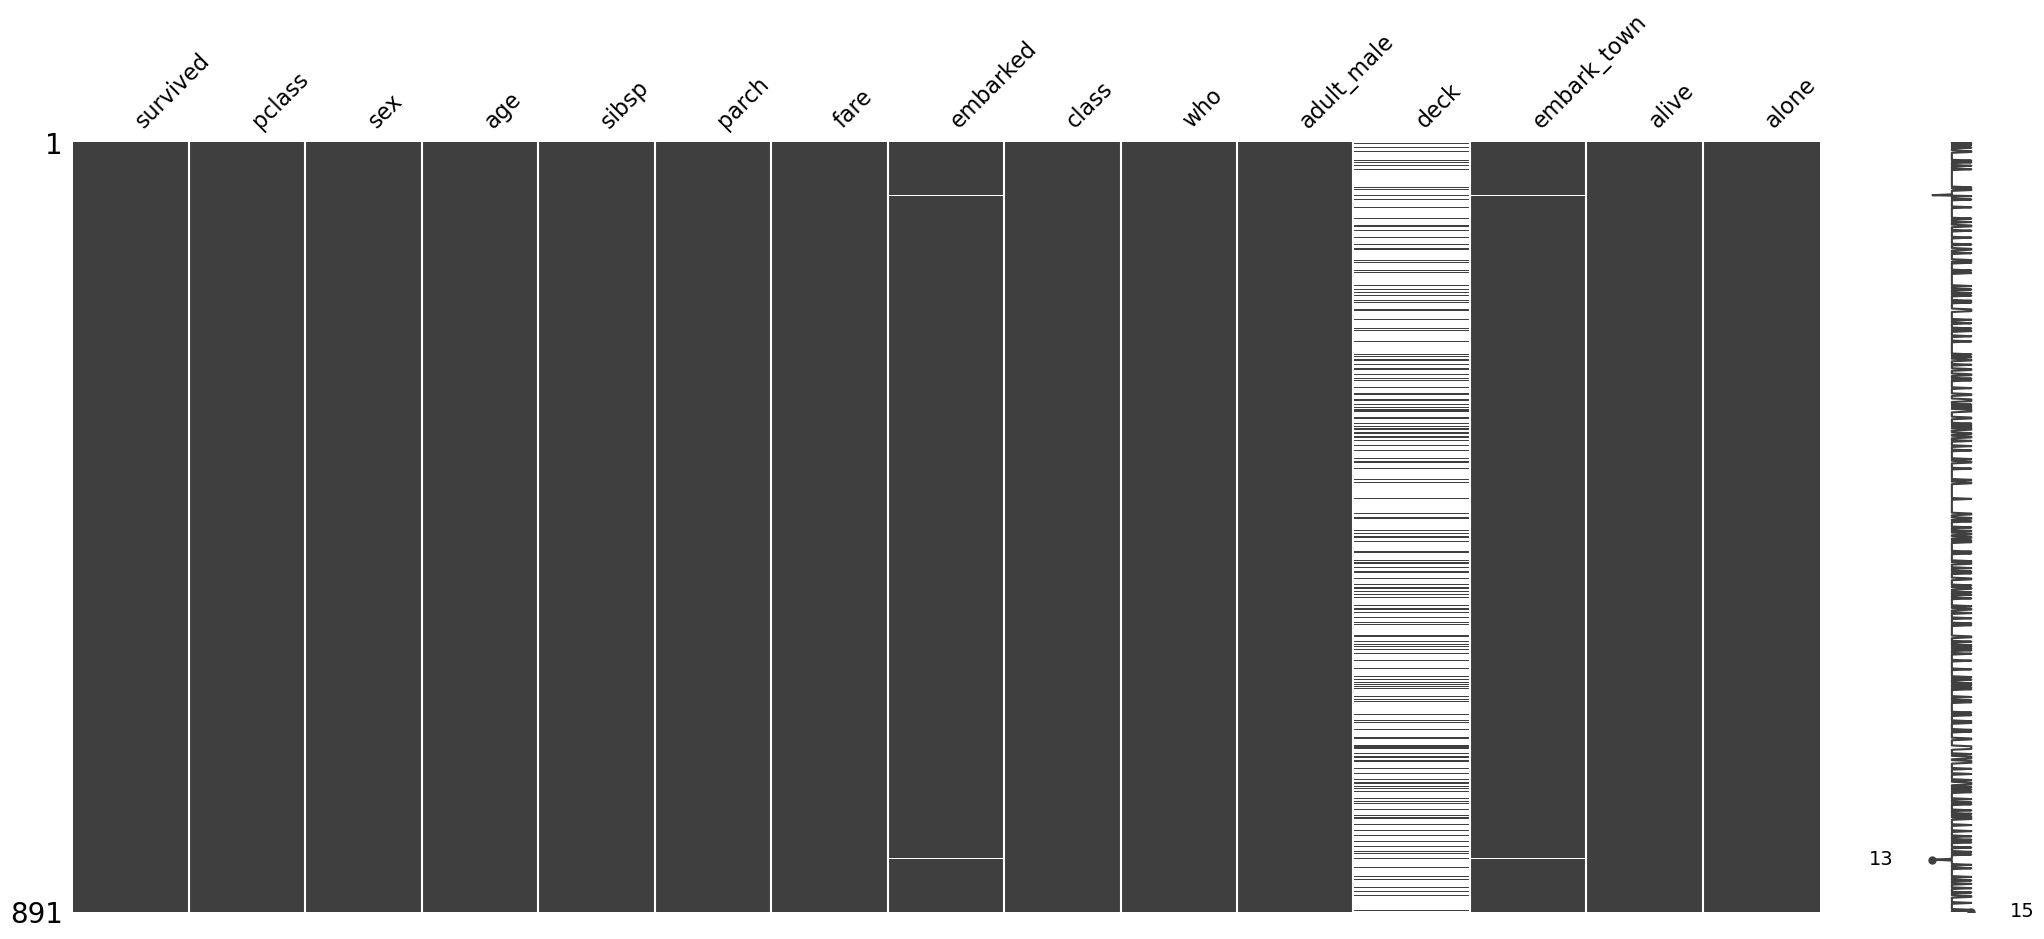

In [18]:
show_missing_value_plot(df, bar=False, heatmap=False)


In [19]:
def missing_vs_target(dataframe, target):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  temp_df = dataframe.copy()
  for col in na_columns:
    temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)

  na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
  for col in na_flags:
    print(pd.DataFrame({"TARGET MEAN": temp_df.groupby(col)[target].mean(),
           "Count": temp_df.groupby(col)[target].count()}), end="\n\n")

In [20]:
missing_vs_target(df, "survived")

                  TARGET MEAN  Count
embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2

              TARGET MEAN  Count
deck_NA_FLAG                    
0                   0.670    203
1                   0.299    688

                     TARGET MEAN  Count
embark_town_NA_FLAG                    
0                          0.382    889
1                          1.000      2

